# Training 1/3 resolution models (318px)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import random
from tqdm import tqdm

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.train_test_val_splitting import *
from levee_hunter.modeling.train import train_model
from levee_hunter.modeling.inference import get_preds_targets
from levee_hunter.modeling.metrics import get_tp_fp_fn
from levee_hunter.modeling.modeling_utils import compute_avg_distance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import GroupKFold

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/ucapmgb/levee-hunter/levee_hunte

### Creating Dataset

In [2]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/masks',
    transform=None,
    weighted=True,
    )

### Training Model

In [3]:
# Define a combined loss function that uses both BCE and Dice loss
class DiceBCELoss(nn.Module):
   def __init__(self, bce_weight=0.5, dice_weight=0.5, mode='binary'):
      super(DiceBCELoss, self).__init__()
      self.bce_weight = bce_weight
      self.dice_weight = dice_weight
      self.bce = nn.BCEWithLogitsLoss()
      self.dice = DiceLoss(mode=mode)
      
   def forward(self, y_pred, y_true):
      bce_loss = self.bce(y_pred, y_true)
      dice_loss = self.dice(y_pred, y_true)
      return self.bce_weight * bce_loss + self.dice_weight * dice_loss

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [7]:
def dice_from_counts(tp, fp, fn):
    """Calculate Dice score from true positives, false positives, and false negatives"""
    return 2 * tp / (2 * tp + fp + fn + 1e-6)

def iou_from_counts(tp, fp, fn):
    """Calculate IoU score from true positives, false positives, and false negatives"""
    return tp / (tp + fp + fn + 1e-6)

In [8]:
# Groups based on filenames
# Extract group IDs from the file paths - keeping everything before "_pX_wY"
groups = []
for path in dataset.img_paths:
   # Convert path to string if it's a Path object
   path_str = str(path)
   # Extract the base pattern without "_pX_wY.tif"
   match = re.search(r'(.+)_p\d+_w\d+\.tif$', path_str)
   if match:
      group_id = match.group(1)
      groups.append(group_id)
   else:
      # Fallback if pattern doesn't match
      groups.append(path_str)

print(f"Total images: {len(groups)}")
print(f"Unique groups: {len(set(groups))}")

unique_groups = list(set(groups))
random.shuffle(unique_groups)
group_to_idx = {g: i for i, g in enumerate(unique_groups)}
group_ids = [group_to_idx[g] for g in groups]

Total images: 1316
Unique groups: 44


In [9]:
# Number of folds for cross-validation
num_folds = 5

# Create a GroupKFold instead of regular KFold
kfold = GroupKFold(n_splits=num_folds)

# Lists to store metrics for each fold
fold_results = []
all_train_losses = []
all_val_losses = []
per_image_results = []  # To store per-image results

# Create a list of all dataset indices
dataset_size = len(dataset)
indices = list(range(dataset_size))

batch_size = 16

for fold, (train_idx, val_idx) in enumerate(kfold.split(indices, groups=group_ids)):
   print(f"Starting fold {fold+1}/{num_folds}")
   
   # Create train and validation subdatasets
   train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
   val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
   
   # Define data loaders for this fold
   fold_train_loader = DataLoader(
      dataset, 
      batch_size=batch_size, 
      sampler=train_subsampler,
      shuffle=False
   )
   
   fold_val_loader = DataLoader(
      dataset,
      batch_size=batch_size,
      sampler=val_subsampler,
      shuffle=False
   )
   
   # Reset model for each fold
   model = smp.UnetPlusPlus(
      encoder_name="resnet50", 
      encoder_weights="imagenet", 
      in_channels=1, 
      classes=1
   ).to(device)
   
   optimizer = optim.Adam(model.parameters(), lr=1e-4)

   # Define model name with fold number to save each fold's model separately
   model_path = f"../models/Unet-13_384_invert_fold{fold+1}.pth"

   model, train_losses, val_losses = train_model(
      model=model,
      train_loader=fold_train_loader,
      test_loader=fold_val_loader,
      optimizer=optimizer,
      criterion=DiceBCELoss(),
      epochs=10,
      suppress_output=True,
      save_model='best',
      save_model_path=model_path,
   )
   
   # Save the losses
   all_train_losses.append(train_losses)
   all_val_losses.append(val_losses)
   
   # Evaluate the model
   model.eval()
   preds, targets = get_preds_targets(model=model, val_loader=fold_val_loader, device=device)

   # Get the actual image indices from the validation sampler
   # We need to map back to the original dataset indices
   val_indices = [val_idx[i] for i in range(len(preds))]
   # Get file names for the validation images
   val_filenames = [dataset.img_paths[idx] for idx in val_indices]
   
   image_metrics = []
   for i in tqdm(range(len(preds)), desc="Processing images"):
      pred = preds[i]
      target = targets[i]
      
      # Calculate metrics for this image
      dice = dice_score(target, pred)
      iou = dice_score(target, pred)
      # tp, fp, fn = get_tp_fp_fn(pred, target, d=3, d_merge=1, visualise=False)
      # dice = dice_from_counts(tp, fp, fn)
      # iou = iou_from_counts(tp, fp, fn)
      distance = compute_avg_distance(pred, target)
      
      image_metrics.append({
         'dice': dice,
         'iou': iou,
         'distance': distance,
         'filename': val_filenames[i]
      })
   
   # Convert to DataFrame
   fold_per_image_results = pd.DataFrame(image_metrics)
   fold_per_image_results['fold'] = fold+1
   per_image_results.append(fold_per_image_results)
   

   # Calculate overall metrics
   print("Calculating overall metrics for this fold...")
   avg_dice = np.mean([m['dice'] for m in image_metrics])
   avg_iou = np.mean([m['iou'] for m in image_metrics])
   avg_distance = np.mean([m['distance'] for m in image_metrics])
   
   # Create metrics dictionary for this fold
   fold_metrics = {
      'fold': fold + 1,
      'dice': avg_dice,
      'iou': avg_iou,
      'distance': avg_distance,
      'val_loss': val_losses[-1]  # Final validation loss
   }
   
   # Append to results list
   fold_results.append(fold_metrics)
   
   print(f"\nFold {fold+1} metrics: \nDice={avg_dice:.4f}, \nIoU={avg_iou:.4f}, \nDistance={avg_distance:.4f}, \nVal Loss={val_losses[-1]:.4f}")

Starting fold 1/5
beginning training on device: cuda
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold1.pth
Trained UnetPlusPlus model with ResNetEncoder encoder.


Processing images: 100%|██████████| 263/263 [00:04<00:00, 59.53it/s]


Calculating overall metrics for this fold...

Fold 1 metrics: 
Dice=0.9964, 
IoU=0.9964, 
Distance=0.0008, 
Val Loss=0.0325
Starting fold 2/5
beginning training on device: cuda
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold2.pth
Trained UnetPlusPlus model with ResNetEncoder encoder.


Processing images: 100%|██████████| 264/264 [00:04<00:00, 57.77it/s]


Calculating overall metrics for this fold...

Fold 2 metrics: 
Dice=0.9977, 
IoU=0.9977, 
Distance=0.0014, 
Val Loss=0.0288
Starting fold 3/5
beginning training on device: cuda
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold3.pth
Trained UnetPlusPlus model with ResNetEncoder encoder.


Processing images: 100%|██████████| 263/263 [00:04<00:00, 58.39it/s]


Calculating overall metrics for this fold...

Fold 3 metrics: 
Dice=0.9965, 
IoU=0.9965, 
Distance=0.0011, 
Val Loss=0.0344
Starting fold 4/5
beginning training on device: cuda
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold4.pth
Trained UnetPlusPlus model with ResNetEncoder encoder.


Processing images: 100%|██████████| 263/263 [00:04<00:00, 56.41it/s]


Calculating overall metrics for this fold...

Fold 4 metrics: 
Dice=0.9979, 
IoU=0.9979, 
Distance=0.0024, 
Val Loss=0.0346
Starting fold 5/5
beginning training on device: cuda
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Model successfully saved to: ../models/Unet-13_384_invert_fold5.pth
Trained UnetPlusPlus model with ResNetEncoder encoder.


Processing images: 100%|██████████| 263/263 [00:04<00:00, 57.71it/s]

Calculating overall metrics for this fold...

Fold 5 metrics: 
Dice=0.9979, 
IoU=0.9979, 
Distance=0.0017, 
Val Loss=0.0334


### Results

In [13]:
# Combine per-image results across all folds
all_per_image_results = pd.concat(per_image_results, ignore_index=True)
# Convert results to floats
all_per_image_results['dice'] = all_per_image_results['dice'].astype(float)
all_per_image_results['iou'] = all_per_image_results['iou'].astype(float)
all_per_image_results['distance'] = all_per_image_results['distance'].astype(float)


# Summarize results across folds
df_results = pd.DataFrame(fold_results)
print("K-fold Cross Validation Results:")
print(df_results)
print("\nMean results across all folds:")
print(df_results.drop('fold', axis=1).mean())

K-fold Cross Validation Results:
   fold      dice       iou  distance  val_loss
0     1  0.996437  0.996437  0.000816  0.032505
1     2  0.997715  0.997715  0.001358  0.028776
2     3  0.996547  0.996547  0.001112  0.034404
3     4  0.997943  0.997943  0.002398  0.034635
4     5  0.997940  0.997940  0.001731  0.033405

Mean results across all folds:
dice        0.997316
iou         0.997316
distance    0.001483
val_loss    0.032745
dtype: float64


### Challenging Images

In [14]:
# Group by original image index and find consistently problematic images
# Calculate mean and std of dice scores for each image across folds
problem_images = all_per_image_results.groupby('filename').agg({
   'dice': ['mean', 'count'],
   'iou': ['mean', 'count'],
   'distance': ['mean', 'count']
})

# Extract just the filename without the directory path
#problem_images.index = problem_images.index.str.replace('/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images/', '')

# Flatten the multi-index columns
problem_images.columns = ['_'.join(col).strip() for col in problem_images.columns.values]

# Sort by mean dice score (ascending) to find the most problematic images
problem_images_sorted = problem_images.sort_values('dice_mean')

print("\nTop 10 most challenging images (lowest average Dice score):")
print(problem_images_sorted.head(10))


Top 10 most challenging images (lowest average Dice score):
                                                    dice_mean  dice_count  \
filename                                                                    
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.980641           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.981538           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.981989           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.983281           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.983389           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.984360           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.985082           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.985390           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.985570           1   
/share/gpu5/ucapmgb/levee-hunter/data/processed...   0.985629           1   

              

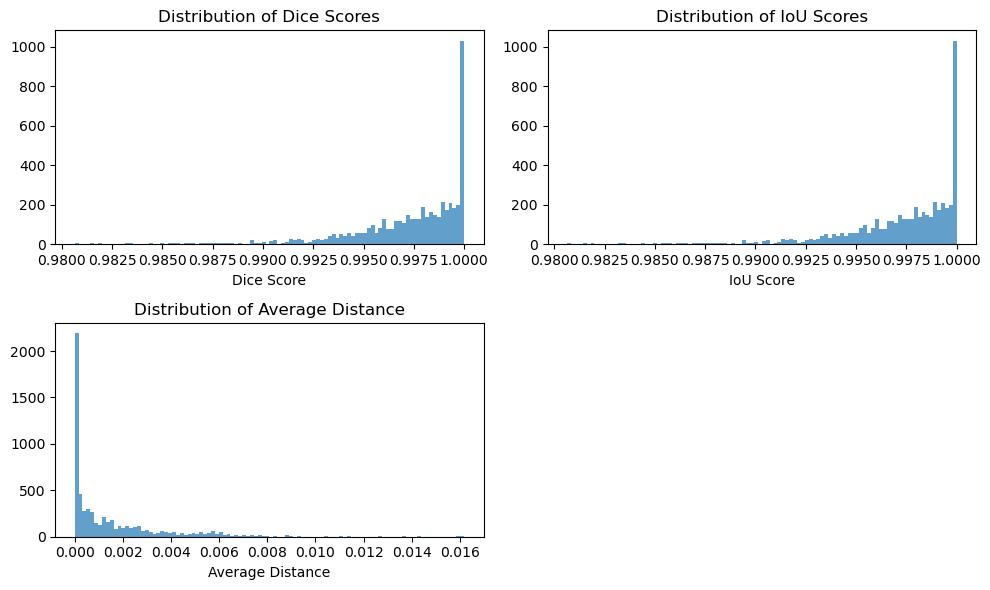

In [18]:
# Visualize per-image metric distributions
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.hist(all_per_image_results['dice'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of Dice Scores')
plt.xlabel('Dice Score')

plt.subplot(2, 2, 2)
plt.hist(all_per_image_results['iou'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU Score')

plt.subplot(2, 2, 3)
plt.hist(all_per_image_results['distance'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of Average Distance')
plt.xlabel('Average Distance')

plt.tight_layout()
plt.show()